In [54]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

import scienceplots

plt.style.use(["science", "nature", "grid", "no-latex"])

from analytical import solve_pair, optimal_cycle_order, find_inequity_of_cycle
from utils import OD_pair, Route

In [55]:
# read csv file
network = "Barcelona"
df = pd.read_csv(f"algorithm_results/single_OD/{network}_OD_to_UE.csv")
print(df.head())
#convert to numpy array columns SO_routes_time and SO_routes_flow
df["SO_routes_time"] = df["SO_routes_time"].apply(
    lambda x: np.array(re.findall(r"\d+\.\d+", x), dtype=float)
)
df["SO_routes_flow"] = df["SO_routes_flow"].apply(
    lambda x: np.array(re.findall(r"\d+\.\d+", x), dtype=float)
)

   origin  destination    SO_time    UE_time      diff   flow  SO_routes_num  \
0       1           24   7.720082   7.720796  0.000714  40.21              2   
1       1           33   9.055381   9.052438 -0.002942  30.85              2   
2       1           38  10.914755  10.913503 -0.001252  15.10              2   
3       1           46  12.760574  12.773686  0.013112   3.31              2   
4       1           94  14.491913  14.503390  0.011477   4.13              2   

                SO_routes_time               SO_routes_flow  
0                 [7.72, 7.73]  [39.88, 0.3299999999999983]  
1    [9.05, 9.059999999999999]                [14.25, 16.6]  
2  [10.91, 10.919999999999998]                 [7.92, 7.18]  
3  [12.759999999999998, 12.77]  [3.12, 0.18999999999999995]  
4   [14.489999999999998, 14.5]                 [3.34, 0.79]  


In [56]:
# analytical solution for each pair
def analytical_solution(row):
    pair = OD_pair(row["origin"], row["destination"], row["flow"])
    for i in range(len(row["SO_routes_time"])):
        route = Route(
            row["SO_routes_time"][i],
            row["SO_routes_flow"][i],
        )
        pair.add_routes(route)
    opt_order, avg_time = optimal_cycle_order(pair.routes)
    inequity = find_inequity_of_cycle(pair.routes, opt_order, avg_time)
    print(f"Inequity: {inequity}")
    res = solve_pair(pair)
    naive = res["naive"]
    gcd = res["gcd"]
    print(f"Naive: {naive}, GCD: {gcd}")
    return {
        "naive": naive,
        "gcd": gcd,
        "opt_order": opt_order,
        "inequity": inequity,
    }

df_results = []
for i, row in df.iterrows():
    print(f"Processing row {i+1}/{len(df)}: {row['origin']} to {row['destination']}")
    result = analytical_solution(row)
    df_results.append({
        "origin": row["origin"],
        "destination": row["destination"],
        "flow": row["flow"],
        "naive": result["naive"],
        "gcd": result["gcd"],
        "opt_order": result["opt_order"],
        "inequity": result["inequity"],
    })
#join results to the df
df_results = pd.DataFrame(df_results)
df = df.join(df_results.set_index(["origin", "destination", "flow"]), on=["origin", "destination", "flow"], rsuffix="_analytical")

Processing row 1/371: 1 to 24
Inequity: [7.888609052210118e-31, 3.1554436208840472e-30, 7.099748146989106e-30, 1.262177448353619e-29, 1.9721522630525295e-29, 2.8398992587956425e-29, 3.865418435582958e-29, 5.048709793414476e-29, 6.389773332290196e-29, 7.888609052210118e-29, 9.545216953174243e-29, 1.135959703518257e-28, 1.33317492982351e-28, 1.5461673742331831e-28, 1.7749370367472766e-28, 2.0194839173657902e-28, 2.279808016088724e-28, 2.5559093329160782e-28, 2.8477878678478526e-28, 3.155443620884047e-28, 3.478876592024662e-28, 3.818086781269697e-28, 4.1730741886191525e-28, 4.543838814073028e-28, 4.930380657631324e-28, 5.33269971929404e-28, 5.750795999061176e-28, 6.184669496932733e-28, 6.634320212908709e-28, 7.099748146989106e-28, 7.5809532991739235e-28, 8.077935669463161e-28, 8.590695257856819e-28, 9.119232064354896e-28, 9.663546088957395e-28, 1.0223637331664313e-27, 1.0799505792475652e-27, 1.139115147139141e-27, 1.199857436841159e-27, 1.2621774483536189e-27]
Naive: 40, GCD: 1
Processing

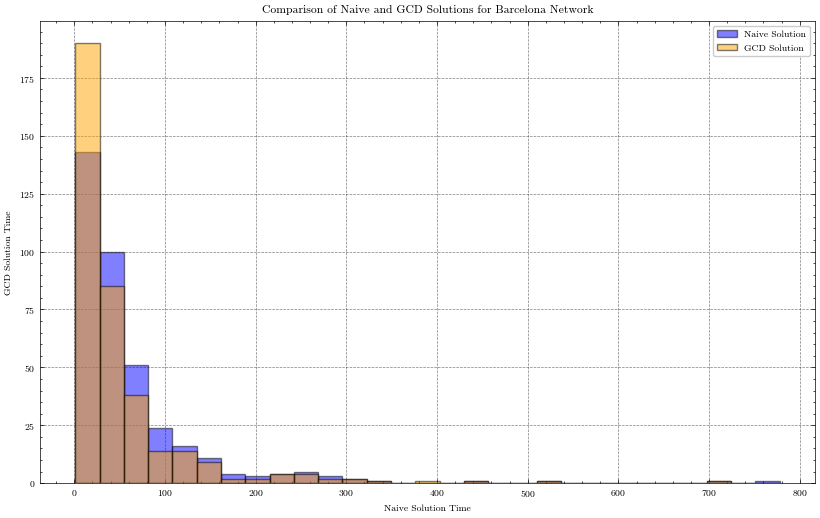

In [57]:
#plot the results
plt.figure(figsize=(10, 6))
#histogram of naive and gcd solutions on the same plot
# keep the bins the same for both histograms
bins = np.linspace(
    min(df["naive"].min(), df["gcd"].min()),
    max(df["naive"].max(), df["gcd"].max()),
    30,
)
plt.hist(
    df["naive"],
    bins=bins,
    alpha=0.5,
    label="Naive Solution",
    color="blue",
    edgecolor="black",
)
plt.hist(
    df["gcd"],
    bins=bins,
    alpha=0.5,
    label="GCD Solution",
    color="orange",
    edgecolor="black",
)
plt.legend()
plt.xlabel("Naive Solution Time")
plt.ylabel("GCD Solution Time")
plt.title(f"Comparison of Naive and GCD Solutions for {network} Network")
plt.grid(True)
plt.savefig(f"tmp_img/{network}_naive_vs_gcd.png", dpi=300, bbox_inches="tight")
plt.show()

In [58]:
# do greedy algorithm for each pair, collect the inequity results